In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score

import pandas as pd
import numpy as np

import copy

## Helpers

In [ ]:
X_train = pd.read_csv('5X_train.csv')
X_test = pd.read_csv('4X_test.csv')
y_train = pd.read_csv('5y_train.csv')
y_test = pd.read_csv('4y_test.csv')

In [ ]:
y_train = y_train['is_canceled']
y_test = y_test['is_canceled']

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
def plot_preds(preds, probas, truth):
    auc_score = roc_auc_score(truth, probas)
    prec = precision_score(truth, preds)
    rec = recall_score(truth, preds)
    f1 = f1_score(truth, preds)
    print(f"AUC: {auc_score:.2f}\n")
    print(f'Precision: {prec:.2f}')
    print(f'Recall: {rec:.2f}')
    print(f"F1: {f1:.2f}\n")

    fpr, tpr, thresholds = roc_curve(truth, probas)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

## Training

In [ ]:
class HotelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HotelDataset(X_train, y_train)
test_dataset = HotelDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 2 Hidden layers

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128) 
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 300
max_val_f1 = 0
patience = 30
wait = 0

best_model = None
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    
    model.eval()
    running_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(torch.round(outputs).cpu().numpy())
        val_loss = running_loss / len(test_loader)
        val_f1 = f1_score(y_true, y_pred)
        
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")
    
    if val_f1 > max_val_f1:
        max_val_f1 = val_f1
        wait = 0
        best_model = copy.deepcopy(model) # fixed reference issue for best model
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

Epoch 1, Train Loss: 0.6276, Val Loss: 0.5817, Val F1: 0.5777
Epoch 2, Train Loss: 0.5785, Val Loss: 0.5512, Val F1: 0.5908
Epoch 3, Train Loss: 0.5612, Val Loss: 0.5471, Val F1: 0.6081
Epoch 4, Train Loss: 0.5491, Val Loss: 0.5444, Val F1: 0.6178
Epoch 5, Train Loss: 0.5376, Val Loss: 0.5360, Val F1: 0.6258
Epoch 6, Train Loss: 0.5291, Val Loss: 0.5203, Val F1: 0.6285
Epoch 7, Train Loss: 0.5233, Val Loss: 0.5345, Val F1: 0.6306
Epoch 8, Train Loss: 0.5181, Val Loss: 0.5270, Val F1: 0.6317
Epoch 9, Train Loss: 0.5140, Val Loss: 0.5199, Val F1: 0.6351
Epoch 10, Train Loss: 0.5087, Val Loss: 0.5196, Val F1: 0.6314
Epoch 11, Train Loss: 0.5074, Val Loss: 0.5092, Val F1: 0.6384
Epoch 12, Train Loss: 0.5037, Val Loss: 0.5227, Val F1: 0.6371
Epoch 13, Train Loss: 0.5010, Val Loss: 0.5150, Val F1: 0.6387
Epoch 14, Train Loss: 0.4978, Val Loss: 0.5082, Val F1: 0.6416
Epoch 15, Train Loss: 0.4962, Val Loss: 0.5109, Val F1: 0.6394
Epoch 16, Train Loss: 0.4926, Val Loss: 0.5102, Val F1: 0.6411
E

Epoch 131, Train Loss: 0.4086, Val Loss: 0.4714, Val F1: 0.6661
Epoch 132, Train Loss: 0.4087, Val Loss: 0.4746, Val F1: 0.6684
Epoch 133, Train Loss: 0.4098, Val Loss: 0.4712, Val F1: 0.6727
Epoch 134, Train Loss: 0.4095, Val Loss: 0.4803, Val F1: 0.6717
Epoch 135, Train Loss: 0.4087, Val Loss: 0.4635, Val F1: 0.6688
Epoch 136, Train Loss: 0.4080, Val Loss: 0.4788, Val F1: 0.6688
Epoch 137, Train Loss: 0.4068, Val Loss: 0.4668, Val F1: 0.6712
Epoch 138, Train Loss: 0.4087, Val Loss: 0.4720, Val F1: 0.6709
Epoch 139, Train Loss: 0.4061, Val Loss: 0.4722, Val F1: 0.6715
Epoch 140, Train Loss: 0.4061, Val Loss: 0.4733, Val F1: 0.6699
Epoch 141, Train Loss: 0.4069, Val Loss: 0.4648, Val F1: 0.6726
Epoch 142, Train Loss: 0.4053, Val Loss: 0.4655, Val F1: 0.6689
Epoch 143, Train Loss: 0.4061, Val Loss: 0.4713, Val F1: 0.6695
Epoch 144, Train Loss: 0.4045, Val Loss: 0.4588, Val F1: 0.6724
Epoch 145, Train Loss: 0.4047, Val Loss: 0.4709, Val F1: 0.6700
Epoch 146, Train Loss: 0.4043, Val Loss:

In [ ]:
best_model.eval()

y_preds = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = best_model(X_batch).squeeze()
        y_preds.extend(outputs.cpu().numpy())
        y_true.extend(y_batch.numpy())

y_preds = np.array(y_preds)
y_preds_binary = (y_preds > 0.5).astype(np.int)

f1 = f1_score(y_true, y_preds_binary)
auc = roc_auc_score(y_true, y_preds)
accuracy = accuracy_score(y_true, y_preds_binary)
prec = precision_score(y_true, y_preds_binary)
rec = recall_score(y_true, y_preds_binary)

print(f'Accuracy: \t{accuracy:.4f}')
print(f"F1 Score: \t{f1:.4f}")
print(f'Recall: \t{rec:.4f}')
print(f'Precision: \t{prec:.4f}')
print(f'ROC AUC: \t{auc:.4f}')

Accuracy: 	0.7693
F1 Score: 	0.6744
Recall: 	0.7746
Precision: 	0.5972
ROC AUC: 	0.8571


C:\Users\admin\AppData\Local\Temp\ipykernel_199876\1220337398.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_preds_binary = (y_preds > 0.5).astype(np.int)


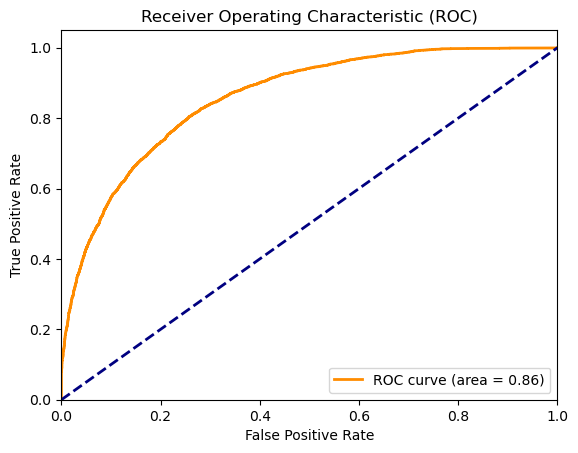

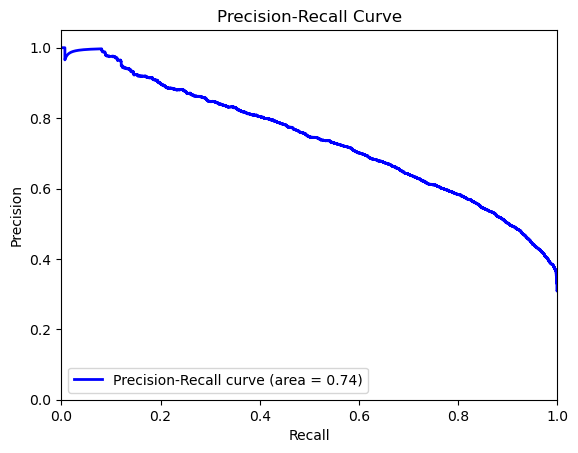

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, _ = roc_curve(y_true, y_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_true, y_preds)
average_precision = average_precision_score(y_true, y_preds)

plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()